<a href="https://colab.research.google.com/github/Ma-Lab-Cal/tmmao/blob/main/optics_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TMM-AO: Optical Physics Package Demonstration**
---
Welcome to this demonstration of the capabilities of the TMM-AO algorithm. Here, we will use TMM-AO to inverse design a multivariate optical element (MOE).

MOEs are optical filters with specific, quantitatively precise transmission (or reflection) profiles. They are essential elements of mutlivariate optical computing, a spectroscopic technique that linearizes data and eliminates interference in the optical rather than digital domain, typically intended to produce a signal that varies linearly with the concentration of a particular analyte, even if other substances are convoluting the spectrum.

MOEs also present an excelent opportunity to showcase the power of TMM-AO, and explain how to use agnostic_director.py. We will take a transmission spectrum computed by [C. Jones](https://scholarcommons.sc.edu/etd/4521/) for an MOE designed to detect methane in petroleum mixtures, and create a device that acheives it using nothing more than an 11 layer, ~3.2μm stack of silicon and silicon dioxide.

If you find any part of the tmmao package helpful and you happen to use it a publication of your own, please cite our work introducing the algorithm:

> N. Morrison, S. Pan, and E. Ma, "Physics-Agnostic Inverse Design Using Transfer Matrices", under review, 2023.

Ok, let's do it!

###Imports
---
First thing we need to do is collect our modules. We're going to grab the modules from GitHub.

In [1]:
!git clone https://github.com/Ma-Lab-Cal/tmmao.git #Clone the github repository. Note that if you run this twice, git will claim to have died because "'tmmao' already exists". This is fine.
import os
os.chdir('tmmao/tmmao/')#Switch to the folder containing all the modules
from agnostic_director import agnostic_director #First, we're going to need the algorith itself.
from optics_physics_package import optics_tmm #Then the physics package
import materials_library #Then all our materials
import numpy as np #We're also going to need numpy
from scipy.interpolate import interp1d #and a linear interpolator

Cloning into 'tmmao'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), 1.02 MiB | 8.02 MiB/s, done.


###Schedulers
---
Next, we need to define our schedulers. These are the things which tell our cost function what weights to assign to various terms. We make a distinction between _physics_ terms in the cost function, which quantify how well the device is perfoming, and _regularization_ terms, which quantify how well the device is matching our other demands like fabrication constraints. The physics term will be the deviation from the target spectrum. The only regualrization term we'll use in this example is a hefty penalty for exceeding a proscribed total footprint.

In [2]:
#First thing to do is define our schedulers. Our target spectrum is an interpolation is this ugly pile of data
xMOE=np.array([1300.984413,1335.438884,1380.721903,1405.33224,1425.020509,1435.849057,1444.708778,1451.599672,1459.474979,1470.303527,1492.945037,1511.648893,1529.368335,1540.196883,1549.056604,1558.900738,1576.62018,1599.26169,1628.794094,1647.497949,1659.310911,1668.170632,1676.045939,
            1683.921247,1690.812141,1697.703035,1704.593929,1712.469237,1720.344545,1728.219852,1737.079573,1748.892535,1761.68991,1780.393765,1796.144381,1815.83265,1830.598852,1844.38064,1854.224774,1862.100082,1872.92863,1884.741591,1905.414274,1928.055783,1953.650533,1979.245283,
            2003.855619,2017.637408,2030.434783,2038.31009,2048.154225,2054.060705,2060.9516,2067.842494,2074.733388,2081.624282,2087.530763,2094.421657,2105.250205,2118.04758,2136.751436,2165.299426,2212.551272,2284.413454,2364.150943,2424.200164,2500.015587])*1E-3
yMOE=np.array([0.218319151,0.433592405,0.429471486,0.973253696,2.827936251,6.212286227,10.47045032,14.72879358,19.205456,22.69901034,25.09944598,24.00570018,21.0555697,17.88765759,15.37515086,13.08096327,10.1308328,9.145933024,10.89051536,13.83733118,16.45716099,19.73248577,22.68028703,
            27.26615381,31.74290581,36.11045344,41.67924912,48.12159016,54.12711373,56.31048441,57.5109262,56.30860312,53.79573805,51.71915293,51.39010647,52.37115408,51.82378846,49.3108338,45.26937632,41.99252859,37.84177717,32.162075,25.49872725,21.12849206,19.70650606,21.34224237,
            27.34624299,34.00645525,42.85084447,49.62079861,57.26420853,61.30423265,62.72326233,61.19377408,54.75008927,48.30640445,41.09837864,33.6718545,24.71611088,18.27188855,11.39031123,6.145903588,3.193085558,1.985297788,1.759632649,0.552919902,0.109293953])*1E-2
f_nirMOE=interp1d(xMOE,yMOE,kind='quadratic',fill_value='extrapolate')

def condition_checker_moe(sim_params):#This is our cfFactorCall. It accepts a sim_params dictionary as an argument.
    """This is our cfFactorCall. It provides weights for the physics terms in the cost function.

    Args:
        sim_params: sim_parameters dictionary. The format is

        {'physics': Type of physics; here, it would be 'optics'
         'simPoint': The current simulation point in simulation scale; here, it would be wavelength in scaled units
         'callPoint': The current simulation point in SI units; here, it would be wavelength in m
         'third_vars':{} The current dictionary of third variables. The keys of this dictionary are whatever you put in it when you run ad.run_optimization()}

    Returns:
        cfFactors: Array-like. List of weights for the physics terms in the cost function at this (simPoint,third_vars) pair.

    For my cost function, in the optics_phsyics_package, the cfFactors are
    [T_linear, #The cost of higher linear transmission
     R_linear, #The cost of higher linear reflection
     T_log, #The cost of higher log transmission
     R_log, #The cost of higher log reflection
     A_linear, #The cost of higher linear absorption
     [T_target,T_cost], #The target transmission (T_target) and the cost of any deviation from that target (T_cost)
     [R_target,R_cost]] #The target reflection (R_target) and the cost of any deviation from that target (R_cost)
    """
    l=sim_params['callPoint']*1E6
    if l<1.3 or l>2.5:
        return [0,0,0,0,0,[0,1],[0,0]]
    else:
        return [0,0,0,0,0,[f_nirMOE(l),1],[0,0]] #I'm only using T_target, attempting to match the target spectrum interpolated above.


fp=10 #Set the footprint constraint as a global value
class dyn_sched:
    """This is our dynamic scheduler.

    It's a class so we can alter its attributes as the optimization progresses.
    """
    def __init__(self):
        self.gi_its=0
        return

    def dynamic_scheduler(self,prevL,curL,it,cur_x,cur_y,prev_factors,no_cb=False): #Note that I do not make much use of the dynamicism of the dynamic scheduler here because it is unnecessary for the problem at hand
        """This is the thing that agnostic_director interfaces with.

        dynamic_scheduler is called everytime callaback() is called by scipy.minimize, allowing it to update the metaparameters governing regularization terms. It's up to you to ensure your cost function is able to interpret the list this method returns.

        Args:
            prevL: Float. The previous iteration's cost function
            curL: Float. The current iteration's cost function
            it: Int. The current iteration. Restarts at 0 every grand iteration. During the presearch phase, will be -1.
            cur_x: Array-like. The current x-parameters. Returned even if x-parameters are not being used as optParams
            cur_y: Array-like. The current y-parameters. Returned even if y-parameters are not being used as optParams
            prev_factors: Array-like. The previous set of factors returned by this method.
            no_cb: If True, it means the dynamic scheduler is being invoked outisde of the callback function. This occurs if minimization fails on the first iteration. If True, IN ADDITION TO the set of factors, the dynamic scheduler must return a bool; if
                   that bool is True, then angostic_invDes will terminate the current grand iteration. If that bool is False, minimize will be called again with the new scheduler factors.

        Return:
            IF no_cb==False:
                rvs: Array-like. Set of factors to be interpreted by the cost function.
            IF no_cb==True:
                termFlag: Bool. If True, then angostic_invDes will terminate the current grand iteration. If False, minimize will be called again with the new scheduler factors.
                rvs: Array-like. Set of factors to be interpreted by the cost function.

        For my cost function, in the optics_phsyics_package, the rvs are
        [matCost, #Material cost. Penalty for using material 2 relative to using material 1.
        atanMag, #Part of footprint constraint. The footprint constraint is atanMag*(np.arctan(atanArg*(total_thickness-footprint))/np.pi+0.5)*np.exp(expArg*(total_thickness-footprint))
        atanArg,
        footprint,
        expArg,
        nonDisc, #Cost of having nondiscrete layers, layers with a y value that is not 0 or 1.
        autoCorr] #Cost of having neighboring layers with different y-values. Increase this number to reduce the number of layers in the final design, provided the optimizer has a means of layer removal.
        """
        matCost,atanMag,atanArg,footprint,expArg=0,70,400,fp,0.2 #Set default values
        if it==-1:
            return [matCost,atanMag,atanArg,footprint,expArg,0,0] #During the presearch, return these values.
        self.gi_its+=1
        rvs=[matCost,atanMag,atanArg,footprint,expArg,prev_factors[5],prev_factors[6]] #During minimization, return these values
        if no_cb: #If callback was not triggered
            return True, rvs #Let agnostic_invDes terminate the grand iteration.
        return rvs
ds=dyn_sched()#Instantiate the dynamic scheduler

###Inverse Design
---
Ok, with our schedulers defined, let's inverse design a MOE. Fair warning: optimization takes some time. It took about 7 minutes last time I ran the following cell, so be prepared to leave it alone and do something else for a bit.

In [3]:
#Ok, with our schedulers defined, let's inverse design a MOE.
ad=agnostic_director() #Instantiate our director

#I'm going to cheat slightly and give you a good set of initial conditions. These were originally generated randomly, but they gave the best spectrum that I found accross ~20 trials (for <12 layers at least - there was an even better one with 22 layers).
#If you'd like to take your chances and roll the dice with some random inits, comment out the following line:
x0=[0.32441199332467563, 0.2421437838701929, 0.47340025698204713, 0.4825611995119943, 0.19989972134583547, 0.14736970395447987, 0.10213421303000284, 0.16361662441880945, 0.2796481376976949, 0.10995312837538893, 0.5725525242494137, 0.19900440425370333]
#x0=3.2 #And uncomment this one

#Load physics functions.
ad.set_physics(physics_package=optics_tmm, #I'm doing an optics optimization in this example, using the optics_physics_package
               mat1Call=materials_library.siliconDioxide, #I'm doing a binary layer stack, with silicon dioxide as one material...
               mat2Call=materials_library.silicon, #... and silicon as the other
               param0Call=materials_library.air, #I'm using air as my incidence medium
               paramNCall=materials_library.bk7, #and bk7 optical glass as my transmission medium
               customInputCall=materials_library.air) #I want to model the very thick bk7 substrate as an incoherent medium, which means I'll need air's refractive index for the bk7-air interface. This function will be called at every simPoint,
                                                      #and the results recorded in a customInput object, which will be sent to the cost function. My cost function knows what data to expect in this object, and will use it as I've programed it to do.

#Load optimizer functions. Must be called ONLY if you're doing an optimization; if just doing analysis, is not necessary, but won't hurt anything.
ad.set_optimizerFunctions(cfFactorCall=condition_checker_moe, #This is the function that assigns weights to particular PHYSICS terms in the cost function. It returns a list; my cost function knows what size of list it should expect
                          schedulerCall=ds.dynamic_scheduler, #This is the function that assigns weights to particular REGULARIZATION terms in the cost function. It returns a list; my cost function knows what size of list it should expect
                          dynamic_scheduling=True, #This enables dynamic scheduling; rather than calling schedulerCall only once each scipy.minimize call, the scheduler will be called every iteration.
                          paramPrunerCall=None) #I could include a function that manaully alters the optParams each iteration, for example eliminating layers that are too small. I do not want to do that here.

#Initialize the structure of the device. Must be called ONLY if you're doing an optimization; if just doing analysis, is not necessary, but won't hurt anything.
ad.set_structure(simType='independent', #I'm using "independent" mode; each layer gets its own transfer matrices. This is opposed to "fixedPoint" mode, as in the quatnum example, where transfer matrices are interpolated between fixed points.
                 num_layers=12, #I want to start with 12 layers. Depending upon other settings, this may or may not be the number of layers in the final design
                 initial_layer_thickness=x0, #I want to start with an overall thickness of 3.2 and random individual layer thicknesses. I could also hand this arg an array-like to specify what I want the inits to be.
                 initial_ys=[1,0]*6, #I want to start with a binary stack of Si-SiO2-Si-SiO2-... If I were to give this an empty list, the initial y's would be randomized. If y_j is e.g. 0.8, then layer j would be 80% Si and 20% SiO2.
                 y_bounds=[0,1], #Bounds for y. Irrelevent in this case since I'm not going to use y's as optimization parameters, but useful if your y's happen to be something other than material ratios
                 x_bounds=[0.005,1], #Bounds for x. I want every layer to have the same bounds; if I wanted different bounds for each, I'd pass a list of two-tuples, with len=num_layers. Minimum layer thickness is 5nm, max 1um.
                 num_intervals=1, #Number of intervals in device. Only meaningful if simType=='fixedPoint'; irrelevent here.
                 substrates=[],superstrates=[]) #No substrates or superstrates necessary. We do have the bk7 substrate, but it's very thick, so we're treating it seperately. See the acoustics example for how to use substrates.

#Define your discretization map. Does a lot more than discretize things; the name is a legacy of old versions of the code. Each entry in the list is one "grand iteration" or "GI". GI0 is reserved for the initial condition.
discretization_map=[{'var_x':True, #I want to use x as optimization parameters in grand iteration 1
                     'var_y':False, #I could also use y as optParams, but I don't want to.
                     'scramble_x':[False,0.02], #I could introduce some artificial noise to bump the cost function out of local minima. If True, this would alter each x-value by up to 2% at the end of grand iteration 1. I don't want to do this.
                     'scramble_y':[False,0.01], #I could also introduce noise for y, but I don't want to do this either
                     'merge_neighbors':[False,0.05], #I could merge redundant layers. If True, any neighboring layers with y-values within 5% of each other would be merged at the end of grand iteration 1. I'm not varying y, so this wouldn't do anything
                     'fully_discretize':False, #I could forcibly discretize all layers at the end of grand iteration 1. This is only useful if y is varying, and then should be used sparingly. Most discretization should be done by the scheduler.
                     'purge_ablated':[False,0.01]}, #I could remove any layer with an x-value less than, say, 0.01 (10 nm). I'm not doing it this grand iteration, but I will after the next.
                     #Because minimize's termination condition is the _relative_ change in the cost function, re-calling minimize after termination with the results of the previous call as inits can yield further optimization
                    {'var_x':True,'var_y':False,'scramble_x':[False,0.02],'scramble_y':[False,0.01],'merge_neighbors':[False,0.05], 'fully_discretize':False,'purge_ablated':[True,0.01]},]#Do the same as in grand iteration 1, but do purge ablated layers

#Run the actual optimization. Must be called ONLY if you're doing an optimization
'''###############################
FAIR WARNING: Optimization might take a hot minute. Last time I tried this problem, it took ~7 min to converge. You might want to go do something else for a few minutes and check in later unless you, like me, find descending cost functions strangely mesmerizing.
Alternatively, make ftol in the run_optimization command bigger, like 1E-4 or something. The final result won't be quite as good, but it will terminate sooner.
###############################'''
ad.run_optimization(simRange=[1.3,2.5], #Set the simulation range for optimization to 1.3um to 2.5um
                    simResolution=60, #Use 60 (technically 61 because of how np.linspace works) simulation points during the optimization
                    third_variables=[{'incidentAngle':0,'polarization':'s'},], #Set the "third variables", any parameters other than wavelength which can change the transfer matrices. Each set of third variables will be simulated seperately,
                                                                               # and all results will be handed to the cost function to deal with. The current set of third variables will be given to all physics package
                                                                               #functions during calls; your physics package/cost function should know what keys to expect in each of these dictionaries.
                                                                               #Here, I'm doing something simple and simulating 0 degrees and s-polarization since the device is meant to be used at normal incidence.
                    discretization_map=discretization_map, #Load the above-defined discretization map. If none is given, a default map with a single entry having var_x=False, var_y=True, and everything else False will be used.
                    simScale=1E-6, #Conversion factor between your simulation scale and SI units. I'm using wavelength in um, so (simPoint)*1E-6=wavelength in m
                    ftol=1E-9, #scipy.minimize ftol argument. Determines the relative reduction in cost function for termination. See minimize documentation.
                    gtol=1E-5, #scipy.minimize gtol argument. Determines the Jacobian value for termination. See minimize documentation.
                    save_name='Moe', #What to call your output pickle. I have decided to name mine Moe.
                    save_directory='/aDrive/afolder/', #Where to save your output pickle. Remember to include final seperation character!
                    save=False, #Whether or not to save the pickle. If you do not save, you will still be able to access the optimization data using the current instance of agnostic_director, but it will be lost when the instance is deleted.
                    logSim=False, #Whether or not to put your simulation points on a log scale. If True, this would spawn 61 points logarithmically between 1.3 and 2.5. If False, linear spacing is used.
                    verbose=1, #How often to have cost function printouts. I want to see the current value of the cost function at every iteration. Set to 0 to turn off all console printouts.
                    evo_preamble_tag='', #A custom tag which is inserted in the evo dictionary's -1 entry, under the aptly-named 'evo_preamble_tag' key. Allows you to record extra custom info about this particular optimization for posterity
                    presearch_threshold=np.inf) #Minimum value of the cost function to begin optimization. New inits will be generated until the cost function falls below this value. Not that ONLY y-values may be re-rolled during presearch
                                                #because I never got around to adding the functionality for x-values. Will not check if the requested threshold is even achievable, so what out for infinite loops. Set to a very large number to turn off.


#At this point, optimization is done. The results are stored in ad.evo. ad.evo[-1] is the "preamble", and stores all the various settings we've chosen above and the names of the physics/optimzation functions we've used, as well as some metadata
#about the optimization itself. ad.evo[0] is a single-element grand iteration, storing only the initial values and initial cost function. After that, there is one ad.evo[i] for each grand iteration i, each of which has one entry for each iteration of
#scipy.minimize. The final entry of ad.evo, ad.evo[I], is a single-element grand iteration storing only the final optParam values and the final cost function. You can pull data from ad.evo and work with it manually, but let's let agnostic_analysis
#do the work for us.



Beginning presearch
Finished presearch
Cost Function: 3.5965273997597618
Initial simulation complete.
Now beginning optimization.
Cost Function: 3.22651509621536
Cost Function: 2.632872329361019
Cost Function: 2.2461739736860986
Cost Function: 2.2284978562061255
Cost Function: 1.7583734042736359
Cost Function: 0.9146563239575811
Cost Function: 0.9073296599398494
Cost Function: 0.6493911007062114
Cost Function: 0.5635197387767468
Cost Function: 0.5525243462168389
Cost Function: 0.41599774136879164
Cost Function: 0.3805422718544951
Cost Function: 0.36497376837571205
Cost Function: 0.3393381562797748
Cost Function: 0.2991149575948498
Cost Function: 0.22837259822081385
Cost Function: 0.1397360595763415
Cost Function: 0.08535912733449307
Cost Function: 0.049939877260724394
Cost Function: 0.049923562132829606
Cost Function: 0.049478130233731966
Cost Function: 0.03663798399469261
Cost Function: 0.033013577981664224
Cost Function: 0.029535384888247272
Cost Function: 0.027866090685609912
Cost F

###Analysis
---
We now have an MOE. But what does it look like, and how well does it actually work? Let's make some pretty pictures and have a look.

Physics package: optics
Preamble tag: 
Simulation type: independent
Material 1 function name: siliconDioxide
Material 2 function name: silicon
param0 function name: air
paramN function name: bk7
customInput function name: air
Third Variables: [{'incidentAngle': 0, 'polarization': 's'}]
Superstrates: []
Substrates: []
Number of grand iterations: 3
Number of iterations in each grand iteration: [1, 380, 4, 1]


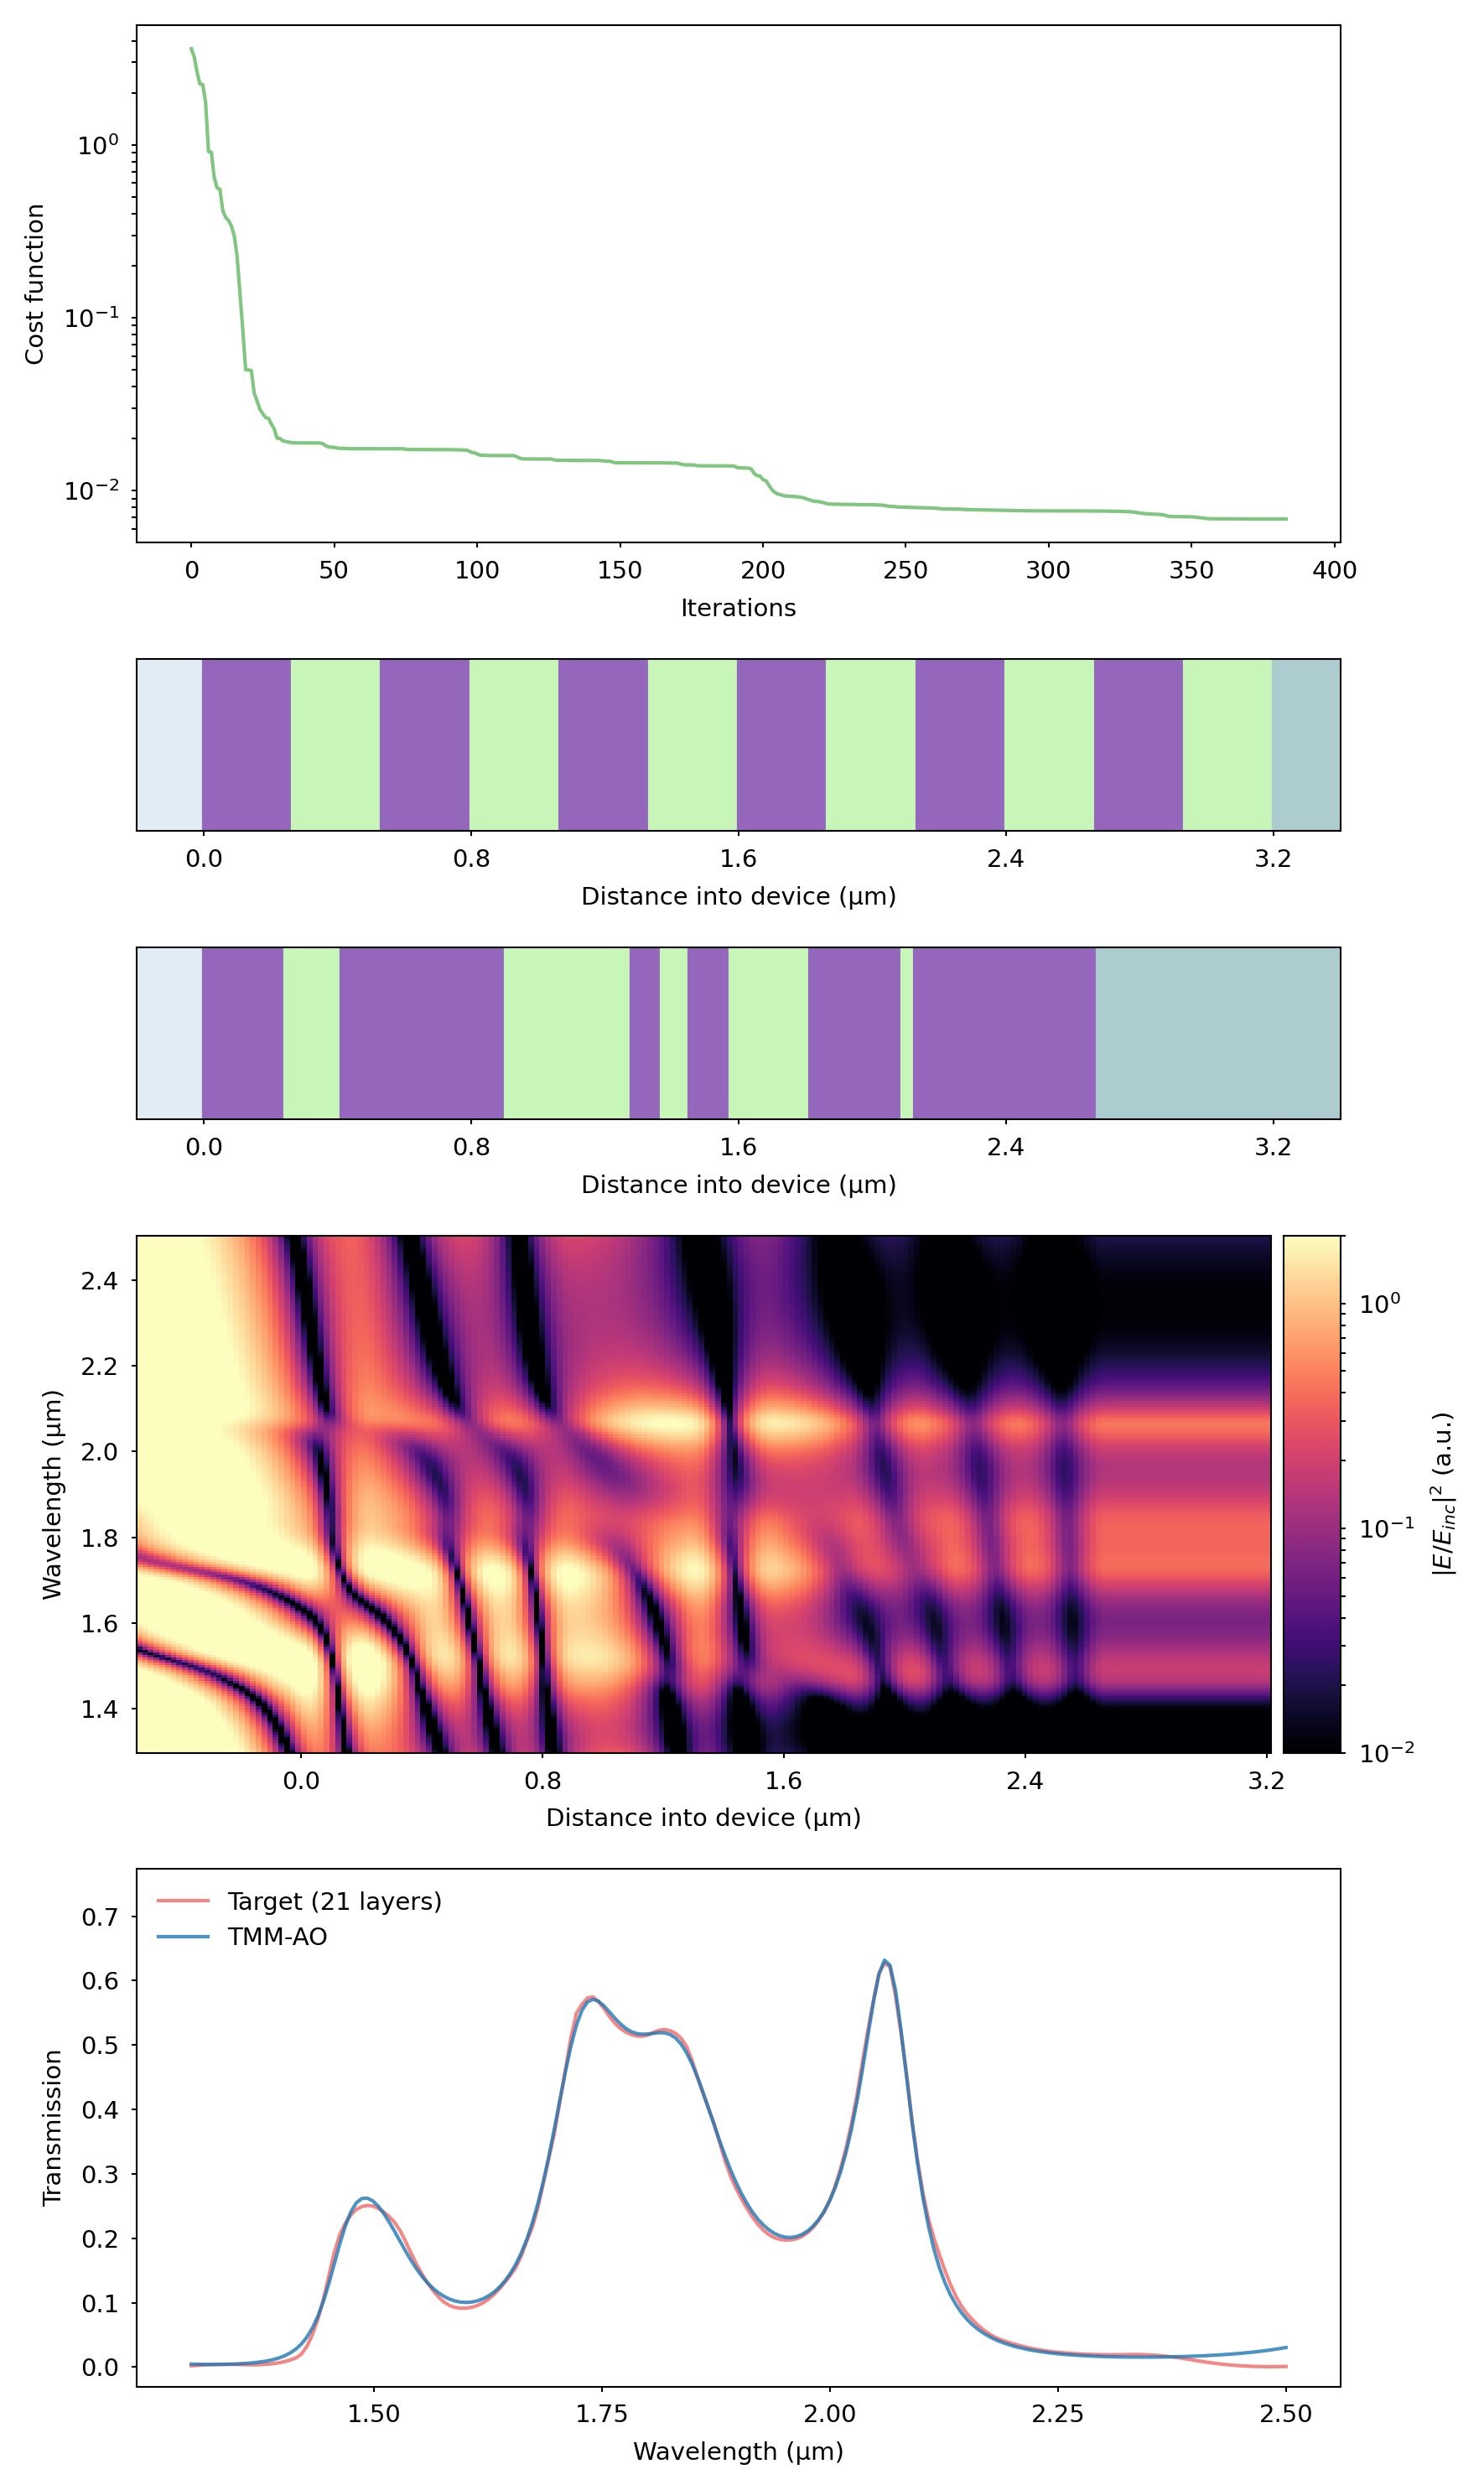

In [5]:
'''
#Pretend several days have passed, and we want to analyze Moe. We'll need to first load the old pickle the optimization generated. If you're doing analysis right after optimization, you DO NOT need to do the following 3 commands; they are only
#necessary if you're doing analysis on old data.
ad=agnostic_director()#Instantiate agnostic_director, which inherits all of agnostic_analysis's methods/attributes.
ad.set_physics(physics_package=optics_tmm,mat1Call=materials_library.silicon,mat2Call=materials_library.siliconDioxide,param0Call=materials_library.air,paramNCall=materials_library.bk7,customInputCall=materials_library.air)#Load physics
ad.load_evo(name='Moe',dir='/aDrive/afolder/') #Load LMoe's pickle, which we stored in '/aDrive/afolder/' during optimization. Now, ad.evo is identical to the ad.evo from Moe's optimization, as if we had just now finished the optimization.
'''

#Starting here, the proceedure is the same whether you're using an imported evo or one from an optimization you just performed.
#I want to make sure I'm analyzing my data properly, so I want to know the settings I used during optimization, like the scale I used for my optParams/simPoints, the materials functions I used, etc. If you want to retrieve this info, call
ad.print_evo_info(sparse=True) #This prints the evo preamble and some other statistics to console. If sparse=True, less information will be provided. This function does nothing but prints ad.evo[-1] and some other stuff in a more readable format

#Initialize parameters analysis simulation. Most of these parameters are recycled from ad.set_structure and ad.run_optimization.
ad.init_analysis(simRange=[1.3,2.5], #The simulation range. Let's keep it the same as during optimization, since this band is all we really care about.
                 simResolution=200, #The number of simulation points. We wanted to use as few points as we could get away with during optimization to minimize simulation time. That's not an issue for analysis, so let's crank it up for smoother plots.
                 simScale=1E-6, #The simulation scale. I'm working with wavelength, in um, so this scale is 1E-6 m per um.
                 simType='independent', #Using 'independent' mode again. I can't think of any reason you would use a different mode for analysis than you did for optimization, but you could theoretically do it with some massaging of ad.evo.
                 third_variables=[{'incidentAngle':0,'polarization':'s'}], #Let's keep looking at normal incidence
                 logSim=False, #Let's keep the simulation points linearly distributed.
                 substrates=[],superstrates=[], #Still no sub/superstrates
                 num_layers=None) #The number of sublayers within each interval if simType=='fixedPoint'. Irrelevent here.

#Initialize our multiplot. The arguments passed to this function are the "global" settings, which apply to the whole pyplot figure.
ad.init_plot(save_name='MoeTableau', #The name of the output plot, minus extension
             save_dir='/aDrive/adifferentfolder/', #Where to save the output plot.
             save=False, #Whether to save the output plot. Again, I'm assuming you do not have the above path on your computer, so let's not do that.
             show=True, #Whether to have pyplot display the output plot
             size=(6,10), #The size of the pyplot figure; first argument is width, second height
             dpi=300, #dpi of the output figure
             dark=False, #A quick way to apply a dark theme: white text, axes, etc. Could also change each color individually, but this is cumbersome
             savetype='.png', #Filetype of output plot. Supports any filetype that pyplot does.
             bbox_inches=None, #If this were a Bbox object, it would cause pyplot to save only the requested portion of the plot. We want all of it, so it's best not to touch this setting.
             tight_layout=True, #Apply tight layout. This should always be done unless pyplot is severely misbehaving
             subplots_adjust={'left':None,'right':None,'top':None,'bottom':None,'hspace':None,'wspace':None}, #Padding along the boarders of the figure and between subplots. See pyplot.subplots documentation. We're not going to touch it here.
             sharex=False, #Whether to have all your plots have the same x-axis. We don't want that
             height_ratios=[3,1,1,3,3]) #Relative height of each subplot. We want them all the same, except for the structure plots which can be 1/3 the height of the rest.

#We now add subplots in the order we wish them to appear. Let's put the cost function at the top. There are a ton of optional arguments. We're going to leave most of them as their defaults.
ad.add_subplotCostFunction(plot_grand_iters=False, #If True, displays a red dot at the start of each grand iteration.
                           lineColor='C2', #Color of the cost function. This could be any named color or a hex code. We're using C2, a dignified green worthy of Moe.
                           linestyle='-', #Style of the line. We're sticking with a solid line.
                           linewidth=1, #Width of the line. We're using 1 point.
                           axiswidth=0.5, #Width of the axis. Pyplot axes tend to be rather generously proportioned, so let's tune it down to 0.5 points.
                           tickwidth=0.5, #Width of the ticks. Usually the same as the axis width
                           ticklength=1.5, #Length of the ticks. Pyplot likes long ticks. I don't. Let's shorten them.
                           xlabel='Iterations', #The x-axis label.
                           ylabel='Cost function', #The y-axis label.
                           labelfontsize=7, #Size of the axis label font in points. Seven should do it.
                           tickfontsize=7, #Size of the tick label font in points. Seven should do it.
                           logy=True, #Whether to do a semilog plot on y. Let's do it to show off more of the cost function. Note that pyplot will cry if you try and do logscale on negative or zero values.
                           grand_iterations=[1,2], #Which grand iterations to plot. We had a two-element discretization map. This means ad.evo has keys -1,0,1,2,3. -1 is the preamble, nothing to plot. 0 is ONLY the initial condition. 3 is ONLY the final
                                                   #structure. We're only interested in what happened during optimziation, so let's just plot 1 and 2. If I left this blank, it would default to [0,1,2,3].
                           alpha=0.6) #Alpha value to apply to the color of the plot line. 0.6 makes C2 a pleasant algal green.

#Let's do the structure plots next. Our inverse design looks pretty funky, and we want everyone to know it. What better way than to juxtapose it with a boring rational design? Let's add a custom structure subplot.
ad.add_subplotStructure(custom_x=[3.2/12]*12, #Let's make it a 12-layer, 3.2um thick device with the layer having uniform thickness
                        custom_y=[1,0]*6, #Let's alternate Si and SiO2
                        labelfontsize=7, #Let's keep the fonts consistent
                        tickfontsize=7,
                        noYticks=True, #The y-axis isn't really telling us anything, so let's turn off the y-axis tick marks
                        color1='#c8f5b8', #Let's make SiO2 grape green
                        color2='C4', #and Si pungent purple.
                        yscale=1, #This number will scale the y-axis. No reason to do it since y-axis isn't telling us anything, so let's keep it at 1.
                        xscale=1, #This number will scale the x-axis. Let's stick to μm
                        xlabel='Distance into device (μm)', #x-axis label
                        ylabel=None, #We don't need or want a y-axis label
                        incident_pad=[0.2,1,'#e2ecf5'], #We don't want the plot to start exactly where the device does. We want to show a bit of the incidence medium. 0.2um of it to be exact.
                        transmission_pad=[0.2,1,'#acccd0'], #Let's show the same amount of transmission medium.
                        xlims=[-0.2,3.4], #Let's plot from 200nm inside the incidence medium to 200nm inside the transmission medium
                        noXticks=False, #We do want x-ticks
                        axiswidth=0.5,tickwidth=0.5,ticklength=1.5,
                        xticklocations=[0,0.8,1.6,2.4,3.2]) #Pyplot puts its ticks in the darndest places. Let's do a manual override.

#That's all well and good, but we're really here for the invDes. Let's plot our final inverse designed structure.
ad.add_subplotStructure(grand_iteration=3, #The final structure is stored in both the last entry of grand iteration 2, and the only entry in grand iteration 3. GI3 is the easier place to find it
                        iteration=0, #There is only one "iteration" in GI3, and it is the final structure.
                        #Everything else will be identical to our custom structure plot.
                        labelfontsize=7,tickfontsize=7,noYticks=True,color1='#c8f5b8',color2='C4',yscale=1,xscale=1,xlabel='Distance into device (μm)',ylabel=None, substrates=[],incident_pad=[0.2,1,'#e2ecf5'],
                        transmission_pad=[1,1,'#acccd0'],xlims=[-0.2,3.4],noXticks=False,axiswidth=0.5,tickwidth=0.5,ticklength=1.5,xticklocations=[0,0.8,1.6,2.4,3.2])

#Now we can admire Moe's grandure and laugh at the pathetic rationality of the periodic multilayer. But what's actually happening inside Moe? Let's plot the electric field distribution to find out
ad.add_subplotFields(grand_iteration=3,iteration=0, #We want the final structure
                     yscale=1,xscale=1, #Let's keep the simulation scales in our plots.
                     resolution=200, #Let's sample the field at 200 points through the depth of the device
                     zlims=[1E-2,2], #We have some areas of the plot with very low electric field because Moe does its job and kills transmission where we tell it to. Let's satruate the color scale for better contrast in the parts we care about
                     colorbarLabel='$|E/E_{inc}|^2$ (a.u.)', #Label on the colorbar axis
                     xlabel='Distance into device (μm)', #Label on the x-axis
                     ylabel='Wavelength (μm)', #Label on the y-axis
                     labelfontsize=7,tickfontsize=7,axiswidth=0.5,tickwidth=0.5,ticklength=1.5, #Keep the same font/axis parameters
                     leftPad=0.2,rightPad=0.2, #Like the structure plots, we want to see some of the incidence/transmisison medium. Let each be 20% the width of the device.
                     physicsPackageArg=[materials_library.air,'intensity'], #This is a simulation, so like the simulations we did during optimization, we need to pass it materials_library.air to get the bk7-air interface. The second element
                                                                            #specifies that we want to plot electric field intensity. These arguments are passed to the interpolate method in the physics package, which knows how to handle them.
                     contourf=False, #Whether to use pyplot.contourf (if True) or pyplot.pcolormesh (if False)
                     colormap='magma', #Let's use the magma scheme because it looks cool.
                     colorbarNorm='log', #Let's use a log scale for the colorbar
                     xticklocations=[0,0.8,1.6,2.4,3.2]) #And let's keep the same tick locations as in the structure plots.

#Last thing we want to see is the response of the device. Let's throw in the target spectrum as well.
#First we need to get the response data. Anything that could be classified as a response of a device is known as an "indicator". Each physics package has a .indicators() method with a list of valid indicator names
ad.get_indicatorsEvo(['TInst'],#Let's grab just the instantaneous transmission. optics_tmm.indicators() knows what 'TInst' means
                     3,0)#For the final structure

del ad.indicator_dict['TInst, avg, [3, 0]'] #All the indicators are stored in ad.indicator_dict. We want to get rid of the polarization-average indicators, since they're identical to the s-polarized indicators at normal incidence.

#We also want the target spectrum. We can add this via the extraPlotSeries argument in add_subplotIndicators. The extraPlotSeries, if provided, must be a dictionary with the same form as ad.indicator_dict. Let's create a custom dataset named "original"
custom_plot={'original':[[],'']}#The first entry of each extraPlotSeries/indicator_dict entry is the array-like of indicators. The second is a string, the units of the indicator. Transmission is unitless, so no unit necessary.
for sp in ad.simPoints: #Make sure we use the exact same simpoints to generate the custom data.
    custom_plot['original'][0].append(f_nirMOE(sp))

#If we want to do any line customization, we're going to need to define dictionaries. Each dictionary should have the same keys as in ad.indicators_dict
datasetLabels={"TInst, {'incidentAngle': 0, 'polarization': 's'}, [3, 0]":'TMM-AO','original':'Target (21 layers)'} #All the indicators have autogenerated names, but they're a bit clunky. Let's rename them
linewidths={"TInst, {'incidentAngle': 0, 'polarization': 's'}, [3, 0]":1,'original':1} #And give them the correct linewidths
lineColors={"TInst, {'incidentAngle': 0, 'polarization': 's'}, [3, 0]":'C0','original':'#f58686'} #And some swanky colors
linestyles={"TInst, {'incidentAngle': 0, 'polarization': 's'}, [3, 0]":'-','original':'-'} #And make them both solid
alphas={"TInst, {'incidentAngle': 0, 'polarization': 's'}, [3, 0]":0.8,'original':1} #And make sure the invDes indicators, which are drawn on top, are a bit transparent so we can see the target beneth it

#Now we can generate the indicators subplot
ad.add_subplotIndicators(ad.indicator_dict, #Use our indicator_dict
                         lineColors=lineColors,linestyles=linestyles,linewidths=linewidths,datasetLabels=datasetLabels,alphas=alphas, #Apply the customization dictionaries we just defined
                         labelfontsize=7,tickfontsize=7,legendfontsize=7,axiswidth=0.5,tickwidth=0.5,ticklength=1.5,
                         xlabel='Wavelength (μm)',ylabel='Transmission', #Set the axis labels
                         legend=True, #We've got two lines going on, so let's put a legend on this one
                         legendframe=False, #Let's ditch the legend frame
                         legendlocation='upper left', #And stick it in the upper left to get it out of the way
                         extraPlotSeries=custom_plot, #Add our target spectrum transmission
                         ylims=[-0.03,0.773], #Let's give the plot a bit more breathing room
                         xticklocations=[1.5,1.75,2.0,2.25,2.5]) #And force the issue on tick placement.

#Now all that's left to do is take a look.
ad.get_plot()

###Conclusion
---
And that's all there is to it! As a recap, to run an optimization with agnostic_director:


*   `ad=agnostic_director()` to instantiate
*   `ad.set_physics()` to load the physics package and material functions
*   `ad.set_optimizerFunctions()` to load the schedulers
*   `ad.set_structure()` to initialize the device
*   `ad.run_optimization()` to run the optimization

When this is done, everything you need to know about the final structure and the optimization process lives in `ad.evo`.

To load data from an old optimizaiton for analysis:

*   `ad=agnostic_director()` to instantiate
*   `ad.set_physics()` to load the physics package and material functions
*   `ad.load_evo()` to load the old `ad.evo` object.
*   `ad.print_evo_info()` to see what optimization parameters were used in the old optimization

To do some analyzing:

*   `ad.init_analysis()` to set up the analysis simulations
*   `ad.init_plot()` to initialize the multiplot
*   `ad.get_indicatorsEvo()` to compute the response of the final or intermediate structure
*   `ad.get_indicatorsCustom()` to compute the response of a custom structure
*   Add whatever subplots you want in the order you want them to appear
    *     `ad.add_subplotCostFunction()` to add a cost function subplot
    *     `ad.add_subplotStructure()` to add a structure subplot
    *     `ad.add_subplotFields()` to add a fields subplot
    *     `ad.add_subplotIndicators()` to add an indicators subplot
*   `ad.get_plot()` to show/save the multiplot

Hope this was helpful! There are a ton of options I didn't cover in this or the other two examples. Be sure to check the docs if you're curious.

